# Average Jobs per district

This notebook calculate the average number of jobs per district in the city o São Paulo in the periodo spamming between 2013 and 2023 (last decade).

The number of jobs were obtained throught the microdata of the RAIS database, made public by the Ministry of Labour of the Federal Government of Brazil (http://pdet.mte.gov.br/microdados-rais-e-caged).

I thank my colleague Maria Gorete da Silva for sharing with me the methodology to calculate this indicator. The data I'm using is publicly available at ObservaSampa.

In [1]:
from core.config import GENERATED_DATA_FOLDER, SHP_FOLDER
from core.utils.file_path import solve_path

In [2]:
import pandas as pd
import geopandas as gpd
import requests

/home/h-pgy/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
total_vinc = pd.read_excel(solve_path('V0434_2006a2021.xlsx', GENERATED_DATA_FOLDER))

In [4]:
total_vinc.head()

,Unnamed: 0,regiao,variavel,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,0,D01,V0434,23558,26273,26828,28198,30915,33165,34877,34402,33619,34371,33826,33975,34744,34895,33616,34687
1,1,D02,V0434,9367,10601,11026,12382,13146,13309,14205,14926,15797,16020,15234,16058,16823,16310,13522,14997
2,2,D03,V0434,2289,2415,2696,2819,3459,4018,3633,3119,2947,2588,2771,2769,2507,2766,2680,2820
3,3,D04,V0434,13856,15859,17231,17541,18886,21576,22828,24392,26553,24401,23163,23178,22565,20610,21080,22026
4,4,D05,V0434,4818,5166,5312,5651,5837,6653,7425,7343,7065,6714,6551,6534,6447,6360,6212,6627


In [5]:
total_vinc.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
pivotado = total_vinc.pivot(index='regiao', 
                 values=[str(ano) for ano in list(range(2006, 2022))], 
                 columns='variavel'
                )

In [7]:
pivotado.columns = pivotado.columns.droplevel(1)

In [8]:
pivotado = pivotado.reset_index()

In [9]:
pivotado.head()

,regiao,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,D01,23558,26273,26828,28198,30915,33165,34877,34402,33619,34371,33826,33975,34744,34895,33616,34687
1,D02,9367,10601,11026,12382,13146,13309,14205,14926,15797,16020,15234,16058,16823,16310,13522,14997
2,D03,2289,2415,2696,2819,3459,4018,3633,3119,2947,2588,2771,2769,2507,2766,2680,2820
3,D04,13856,15859,17231,17541,18886,21576,22828,24392,26553,24401,23163,23178,22565,20610,21080,22026
4,D05,4818,5166,5312,5651,5837,6653,7425,7343,7065,6714,6551,6534,6447,6360,6212,6627


In [10]:
del total_vinc

In [11]:
n_class = pivotado.iloc[-1,:]

In [12]:
val_anos = pivotado.iloc[:-1,1:].sum()

In [13]:
percent_n_class = n_class/val_anos

In [14]:
percent_n_class

2006      0.222921
2007      0.209936
2008      0.204481
2009      0.211507
2010       0.18301
2011      0.171849
2012       0.18805
2013      0.159146
2014      0.198288
2015      0.145164
2016      0.067715
2017      0.067652
2018      0.074315
2019      0.059263
2020      0.058808
2021      0.068333
regiao         NaN
dtype: object

In [15]:
anos_selecionados = [str(i) for i in range(2016, 2022)]

In [16]:
df_vinculos = pivotado[['regiao'] + anos_selecionados].copy()

In [17]:
del pivotado

In [18]:
df_vinculos['media'] = df_vinculos[anos_selecionados].apply(lambda row: row.mean(), axis=1)

In [19]:
df_vinculos

,regiao,2016,2017,2018,2019,2020,2021,media
0,D01,33826,33975,34744,34895,33616,34687,34290.500000
1,D02,15234,16058,16823,16310,13522,14997,15490.666667
2,D03,2771,2769,2507,2766,2680,2820,2718.833333
3,D04,23163,23178,22565,20610,21080,22026,22103.666667
4,D05,6551,6534,6447,6360,6212,6627,6455.166667
...,...,...,...,...,...,...,...,...
92,D93,24843,24936,25679,28176,25903,28097,26272.333333
93,D94,33798,30081,32365,30841,34525,31881,32248.500000
94,D95,64439,61501,65274,74773,77871,94788,73107.666667
95,D96,24987,24401,24917,25779,24887,28141,25518.666667


In [20]:
with requests.get('https://api.observasampa.prefeitura.sp.gov.br/v1/basic/regioes/?cd_nivel_regiao=1') as r:
    regioes_observa = r.json()

In [21]:
mapper_codigo_regiao = {f'D{str(reg["cd_regiao"])[1:]}' : reg['nm_regiao_padrao']
                        for reg in regioes_observa}

In [22]:
df_vinculos['ds_nome'] = df_vinculos['regiao'].map(mapper_codigo_regiao)

In [23]:
df_vinculos.head()

,regiao,2016,2017,2018,2019,2020,2021,media,ds_nome
0,D01,33826,33975,34744,34895,33616,34687,34290.500000,AGUA RASA
1,D02,15234,16058,16823,16310,13522,14997,15490.666667,ALTO DE PINHEIROS
2,D03,2771,2769,2507,2766,2680,2820,2718.833333,ANHANGUERA
3,D04,23163,23178,22565,20610,21080,22026,22103.666667,ARICANDUVA
4,D05,6551,6534,6447,6360,6212,6627,6455.166667,ARTUR ALVIM


In [24]:
folder_distritos = solve_path('distritos', SHP_FOLDER)
shp_distritos_file = solve_path('SIRGAS_SHP_distrito', folder_distritos)

In [25]:
shp_dists = gpd.read_file(shp_distritos_file)

In [26]:
shp_dists.head()

,ds_nome,ds_codigo,ds_cd_sub,ds_subpref,ds_sigla,ds_areamt,ds_areakm,geometry
0,MANDAQUI,51,05,SANTANA-TUCURUVI,MAN,1.324786e+07,13.248,"POLYGON ((330950.373 7407837.176, 330952.177 7..."
1,MOOCA,53,25,MOOCA,MOO,7.948972e+06,7.949,"POLYGON ((338349.356 7394264.944, 338362.239 7..."
2,CIDADE ADEMAR,22,16,CIDADE ADEMAR,CAD,1.234284e+07,12.343,"POLYGON ((332332.417 7381170.543, 332348.402 7..."
3,TREMEMBE,81,06,JACANA-TREMEMBE,TRE,5.671477e+07,56.715,"POLYGON ((337037.395 7403901.769, 337033.929 7..."
4,SAO LUCAS,72,29,VILA PRUDENTE,SLU,9.675986e+06,9.676,"POLYGON ((340488.820 7391250.151, 340501.069 7..."


In [27]:
df_vinculos = df_vinculos.drop('regiao', axis=1)

In [28]:
#removendo linha final que é o nao encontrado
df_vinculos = df_vinculos.iloc[:-1, :]

In [29]:
merged = pd.merge(df_vinculos, shp_dists, on='ds_nome', how='outer')

In [30]:
df_final = gpd.GeoDataFrame(merged)

In [31]:
df_final.crs

In [32]:
df_final = df_final.set_crs(epsg=31983)

In [33]:
df_final.columns

Index(['2016', '2017', '2018', '2019', '2020', '2021', 'media', 'ds_nome',
       'ds_codigo', 'ds_cd_sub', 'ds_subpref', 'ds_sigla', 'ds_areamt',
       'ds_areakm', 'geometry'],
      dtype='object')

In [34]:
df_final['percent_empregos'] = df_final['media']/df_final['media'].sum()

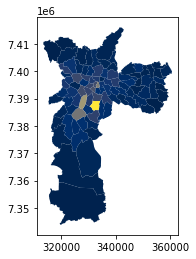

In [35]:
f = df_final.plot('percent_empregos', cmap='cividis')

In [36]:
f.get_figure().savefig('mapa.jpeg')

In [37]:
df_final.sort_values(by='percent_empregos', ascending=False)[['ds_nome', 'percent_empregos']]

,ds_nome,percent_empregos
76,SAUDE,0.101955
34,ITAIM BIBI,0.066347
77,SE,0.053162
70,SANTO AMARO,0.047735
6,BELA VISTA,0.030050
...,...,...
4,ARTUR ALVIM,0.001394
60,PERUS,0.001319
51,MARSILAC,0.000957
32,IGUATEMI,0.000933


In [38]:
df_final=df_final[['ds_nome', 'percent_empregos']]

In [39]:
df_final.to_csv(solve_path('percent_empregos_por_dist.csv', GENERATED_DATA_FOLDER),
               index=False, sep=';', encoding='utf-8')